# Data preprocessing modified from XD_XD

## Some helper functions

In [1]:
from pathlib import Path
import argparse
import math
import glob

import click
import scipy
import tqdm
import tables as tb
import pandas as pd
import numpy as np
import skimage.transform
import rasterio
import shapely.wkt
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
datapath = '/data/train/AOI_3_Paris_Train'
MODEL_NAME = 'v5'
ORIGINAL_SIZE = 650
INPUT_SIZE = 256

BASE_TRAIN_DIR = "/data/train"
WORKING_DIR = "/data/working"
IMAGE_DIR = "/data/working/images/v5"

# Input files
FMT_TRAIN_SUMMARY_PATH = str(
    Path(BASE_TRAIN_DIR) /
    Path("{prefix:s}_Train/") /
    Path("summaryData/{prefix:s}_Train_Building_Solutions.csv"))
FMT_TRAIN_RGB_IMAGE_PATH = str(
    Path("{datapath:s}/") /
    Path("RGB-PanSharpen/RGB-PanSharpen_{image_id:s}.tif"))
FMT_TEST_RGB_IMAGE_PATH = str(
    Path("{datapath:s}/") /
    Path("RGB-PanSharpen/RGB-PanSharpen_{image_id:s}.tif"))
FMT_TRAIN_MSPEC_IMAGE_PATH = str(
    Path("{datapath:s}/") /
    Path("MUL-PanSharpen/MUL-PanSharpen_{image_id:s}.tif"))
FMT_TEST_MSPEC_IMAGE_PATH = str(
    Path("{datapath:s}/") /
    Path("MUL-PanSharpen/MUL-PanSharpen_{image_id:s}.tif"))

# Preprocessing result
FMT_RGB_BANDCUT_TH_PATH = IMAGE_DIR + "/rgb_bandcut{}.csv"
FMT_MUL_BANDCUT_TH_PATH = IMAGE_DIR + "/mul_bandcut{}.csv"

# Image list, Image container and mask container
FMT_VALTRAIN_IMAGELIST_PATH = IMAGE_DIR + "/{prefix:s}_valtrain_ImageId.csv"
FMT_VALTRAIN_MASK_STORE = IMAGE_DIR + "/valtrain_{}_mask.h5"
FMT_VALTRAIN_IM_STORE = IMAGE_DIR + "/valtrain_{}_im.h5"
FMT_VALTRAIN_MUL_STORE = IMAGE_DIR + "/valtrain_{}_mul.h5"

FMT_VALTEST_IMAGELIST_PATH = IMAGE_DIR + "/{prefix:s}_valtest_ImageId.csv"
FMT_VALTEST_MASK_STORE = IMAGE_DIR + "/valtest_{}_mask.h5"
FMT_VALTEST_IM_STORE = IMAGE_DIR + "/valtest_{}_im.h5"
FMT_VALTEST_MUL_STORE = IMAGE_DIR + "/valtest_{}_mul.h5"

FMT_IMMEAN = IMAGE_DIR + "/{}_immean.h5"
FMT_MULMEAN = IMAGE_DIR + "/{}_mulmean.h5"

FMT_TEST_IMAGELIST_PATH = IMAGE_DIR + "/{prefix:s}_test_ImageId.csv"
FMT_TEST_IM_STORE = IMAGE_DIR + "/test_{}_im.h5"
FMT_TEST_MUL_STORE = IMAGE_DIR + "/test_{}_mul.h5"

In [3]:
def directory_name_to_area_id(datapath):
    """
    Directory name to AOI number

    Usage:

        >>> directory_name_to_area_id("/data/test/AOI_2_Vegas")
        2
    """
    dir_name = Path(datapath).name
    if dir_name.startswith('AOI_2_Vegas'):
        return 2
    elif dir_name.startswith('AOI_3_Paris'):
        return 3
    elif dir_name.startswith('AOI_4_Shanghai'):
        return 4
    elif dir_name.startswith('AOI_5_Khartoum'):
        return 5
    else:
        raise RuntimeError("Unsupported city id is given.")
        
def image_id_to_prefix(image_id):
    """
    `AOI_3_Paris_img585` -> `AOI_3_Paris`
    """
    prefix = image_id.split('img')[0][:-1]
    return prefix


def prefix_to_area_id(prefix):
    area_dict = {
        'AOI_2_Vegas': 2,
        'AOI_3_Paris': 3,
        'AOI_4_Shanghai': 4,
        'AOI_5_Khartoum': 5,
    }
    return area_dict[area_id]


def area_id_to_prefix(area_id):
    area_dict = {
        2: 'AOI_2_Vegas',
        3: 'AOI_3_Paris',
        4: 'AOI_4_Shanghai',
        5: 'AOI_5_Khartoum',
    }
    return area_dict[area_id]


In [4]:
def calc_rgb_multiband_cut_threshold(area_id, datapath):
    rows = []
    band_cut_th = __calc_rgb_multiband_cut_threshold(area_id, datapath)
    prefix = area_id_to_prefix(area_id)
    row = dict(prefix=area_id_to_prefix(area_id))
    row['area_id'] = area_id
    for chan_i in band_cut_th.keys():
        row['chan{}_max'.format(chan_i)] = band_cut_th[chan_i]['max']
        row['chan{}_min'.format(chan_i)] = band_cut_th[chan_i]['min']
    rows.append(row)
    pd.DataFrame(rows).to_csv(
        FMT_RGB_BANDCUT_TH_PATH.format(prefix), index=False)


def __calc_rgb_multiband_cut_threshold(area_id, datapath):
    prefix = area_id_to_prefix(area_id)
    band_values = {k: [] for k in range(3)}
    band_cut_th = {k: dict(max=0, min=0) for k in range(3)}

    image_id_list = pd.read_csv(FMT_VALTRAIN_IMAGELIST_PATH.format(
        prefix=prefix)).ImageId.tolist()
    for image_id in tqdm.tqdm(image_id_list[:500]):
        image_fn = get_train_image_path_from_imageid(image_id, datapath)
        with rasterio.open(image_fn, 'r') as f:
            values = f.read().astype(np.float32)
            for i_chan in range(3):
                values_ = values[i_chan].ravel().tolist()
                values_ = np.array(
                    [v for v in values_ if v != 0]
                )  # Remove sensored mask
                band_values[i_chan].append(values_)

    image_id_list = pd.read_csv(FMT_VALTEST_IMAGELIST_PATH.format(
        prefix=prefix)).ImageId.tolist()
    for image_id in tqdm.tqdm(image_id_list[:500]):
        image_fn = get_train_image_path_from_imageid(image_id, datapath)
        with rasterio.open(image_fn, 'r') as f:
            values = f.read().astype(np.float32)
            for i_chan in range(3):
                values_ = values[i_chan].ravel().tolist()
                values_ = np.array(
                    [v for v in values_ if v != 0]
                )  # Remove sensored mask
                band_values[i_chan].append(values_)

    print("Calc percentile point ...")
    for i_chan in range(3):
        band_values[i_chan] = np.concatenate(
            band_values[i_chan]).ravel()
        band_cut_th[i_chan]['max'] = scipy.percentile(
            band_values[i_chan], 98)
        band_cut_th[i_chan]['min'] = scipy.percentile(
            band_values[i_chan], 2)
    return band_cut_th

In [5]:
def _load_train_summary_data(area_id):
    prefix = area_id_to_prefix(area_id)
    fn = FMT_TRAIN_SUMMARY_PATH.format(prefix=prefix)
    df = pd.read_csv(fn)
    # df.loc[:, 'ImageId'] = df.ImageId.str[4:]
    return df

def prep_valtrain_valtest_imagelist(area_id):
    prefix = area_id_to_prefix(area_id)
    df = _load_train_summary_data(area_id)
    df_agg = df.groupby('ImageId').agg('first')

    image_id_list = df_agg.index.tolist()
    np.random.shuffle(image_id_list)
    sz_valtrain = int(len(image_id_list) * 0.7)
    sz_valtest = len(image_id_list) - sz_valtrain

    base_dir = Path(FMT_VALTRAIN_IMAGELIST_PATH.format(prefix=prefix)).parent
    if not base_dir.exists():
        base_dir.mkdir(parents=True)

    pd.DataFrame({'ImageId': image_id_list[:sz_valtrain]}).to_csv(
        FMT_VALTRAIN_IMAGELIST_PATH.format(prefix=prefix),
        index=False)
    pd.DataFrame({'ImageId': image_id_list[sz_valtrain:]}).to_csv(
        FMT_VALTEST_IMAGELIST_PATH.format(prefix=prefix),
        index=False)

In [6]:
def get_train_image_path_from_imageid(image_id, datapath, mul=False):
    prefix = image_id_to_prefix(image_id)
    if mul:
        return FMT_TRAIN_MSPEC_IMAGE_PATH.format(
            datapath=datapath, prefix=prefix, image_id=image_id)
    else:
        return FMT_TRAIN_RGB_IMAGE_PATH.format(
            datapath=datapath, prefix=prefix, image_id=image_id)


def get_test_image_path_from_imageid(image_id, datapath, mul=False):
    prefix = image_id_to_prefix(image_id)
    if mul:
        return FMT_TEST_MSPEC_IMAGE_PATH.format(
            datapath=datapath, image_id=image_id)
    else:
        return FMT_TEST_RGB_IMAGE_PATH.format(
            datapath=datapath, image_id=image_id)

In [7]:
def prep_image_mask(area_id, is_valtrain=True):
    prefix = area_id_to_prefix(area_id)
    print("prep_image_mask for {}".format(prefix))
    if is_valtrain:
        fn_list = FMT_VALTRAIN_IMAGELIST_PATH.format(prefix=prefix)
        fn_mask = FMT_VALTRAIN_MASK_STORE.format(prefix)
    else:
        fn_list = FMT_VALTEST_IMAGELIST_PATH.format(prefix=prefix)
        fn_mask = FMT_VALTEST_MASK_STORE.format(prefix)

    df = pd.read_csv(fn_list, index_col='ImageId')
    df_summary = _load_train_summary_data(area_id)
    print("Prepare image container: {}".format(fn_mask))
    with tb.open_file(fn_mask, 'w') as f:
        for image_id in tqdm.tqdm(df.index, total=len(df)):
            im_mask = image_mask_resized_from_summary(df_summary, image_id)
            atom = tb.Atom.from_dtype(im_mask.dtype)
            filters = tb.Filters(complib='blosc', complevel=9)
            ds = f.create_carray(f.root, image_id, atom, im_mask.shape,
                                 filters=filters)
            ds[:] = im_mask

In [8]:
def image_mask_resized_from_summary(df, image_id):
    im_mask = np.zeros((650, 650))

    if len(df[df.ImageId == image_id]) == 0:
        raise RuntimeError("ImageId not found on summaryData: {}".format(
            image_id))

    for idx, row in df[df.ImageId == image_id].iterrows():
        shape_obj = shapely.wkt.loads(row.PolygonWKT_Pix)
        if shape_obj.exterior is not None:
            coords = list(shape_obj.exterior.coords)
            x = [round(float(pp[0])) for pp in coords]
            y = [round(float(pp[1])) for pp in coords]
            yy, xx = skimage.draw.polygon(y, x, (650, 650))
            im_mask[yy, xx] = 1

            interiors = shape_obj.interiors
            for interior in interiors:
                coords = list(interior.coords)
                x = [round(float(pp[0])) for pp in coords]
                y = [round(float(pp[1])) for pp in coords]
                yy, xx = skimage.draw.polygon(y, x, (650, 650))
                im_mask[yy, xx] = 0
    im_mask = skimage.transform.resize(im_mask, (INPUT_SIZE, INPUT_SIZE))
    im_mask = (im_mask > 0.5).astype(np.uint8)
    return im_mask

In [9]:
def prep_rgb_image_store_train(area_id, datapath, is_valtrain=True):
    prefix = area_id_to_prefix(area_id)
    bandstats = __load_rgb_bandstats(area_id)

    print("prep_rgb_image_store_train for {}".format(prefix))
    if is_valtrain:
        fn_list = FMT_VALTRAIN_IMAGELIST_PATH.format(prefix=prefix)
        fn_store = FMT_VALTRAIN_IM_STORE.format(prefix)
    else:
        fn_list = FMT_VALTEST_IMAGELIST_PATH.format(prefix=prefix)
        fn_store = FMT_VALTEST_IM_STORE.format(prefix)

    df_list = pd.read_csv(fn_list, index_col='ImageId')

    print("Image store file: {}".format(fn_store))
    with tb.open_file(fn_store, 'w') as f:
        for image_id in tqdm.tqdm(df_list.index, total=len(df_list)):
            im = get_resized_3chan_image_train(image_id, datapath, bandstats)
            atom = tb.Atom.from_dtype(im.dtype)
            filters = tb.Filters(complib='blosc', complevel=9)
            ds = f.create_carray(f.root, image_id, atom, im.shape,
                                 filters=filters)
            ds[:] = im
            
def __load_rgb_bandstats(area_id):
    """
    Usage:

        >>> __load_rgb_bandstats(3)
        {
          0: {
              'max': 462.0,
              'min': 126.0,
          },
          1: {
              'max': 481.0,
              'min': 223.0,
          },
          2: {
              'max': 369.0,
              'min': 224.0,
          },
        }
    """
    prefix = area_id_to_prefix(area_id)
    fn_stats = FMT_RGB_BANDCUT_TH_PATH.format(prefix)
    df_stats = pd.read_csv(fn_stats, index_col='area_id')
    r = df_stats.loc[area_id]

    stats_dict = {}
    for chan_i in range(3):
        stats_dict[chan_i] = dict(
            min=r['chan{}_min'.format(chan_i)],
            max=r['chan{}_max'.format(chan_i)])
    return stats_dict

def get_resized_3chan_image_train(image_id, datapath, bandstats):
    fn = get_train_image_path_from_imageid(image_id, datapath)
    with rasterio.open(fn, 'r') as f:
        values = f.read().astype(np.float32)
        for chan_i in range(3):
            min_val = bandstats[chan_i]['min']
            max_val = bandstats[chan_i]['max']
            values[chan_i] = np.clip(values[chan_i], min_val, max_val)
            values[chan_i] = (values[chan_i] - min_val) / (max_val - min_val)

    values = np.swapaxes(values, 0, 2)
    values = np.swapaxes(values, 0, 1)
    values = skimage.transform.resize(values, (INPUT_SIZE, INPUT_SIZE))
    return values

In [10]:
def prep_immean(area_id, datapath):
    prefix = area_id_to_prefix(area_id)
    X_train = []

    # Load valtrain
    fn_im = FMT_VALTRAIN_IM_STORE.format(prefix)
    image_list = pd.read_csv(FMT_VALTRAIN_IMAGELIST_PATH.format(
        prefix=prefix)).ImageId.tolist()
    with tb.open_file(fn_im, 'r') as f:
        for idx, image_id in enumerate(image_list):
            im = np.array(f.get_node('/' + image_id))
            im = np.swapaxes(im, 0, 2)
            im = np.swapaxes(im, 1, 2)
            X_train.append(im)

    # Load valtest
    fn_im = FMT_VALTEST_IM_STORE.format(prefix)
    image_list = pd.read_csv(FMT_VALTEST_IMAGELIST_PATH.format(
        prefix=prefix)).ImageId.tolist()
    with tb.open_file(fn_im, 'r') as f:
        for idx, image_id in enumerate(image_list):
            im = np.array(f.get_node('/' + image_id))
            im = np.swapaxes(im, 0, 2)
            im = np.swapaxes(im, 1, 2)
            X_train.append(im)

    X_mean = np.array(X_train).mean(axis=0)

    fn = FMT_IMMEAN.format(prefix)
    print("Prepare mean image: {}".format(fn))
    with tb.open_file(fn, 'w') as f:
        atom = tb.Atom.from_dtype(X_mean.dtype)
        filters = tb.Filters(complib='blosc', complevel=9)
        ds = f.create_carray(f.root, 'immean', atom, X_mean.shape,
                             filters=filters)
        ds[:] = X_mean

## Begin preprocessing

In [11]:
area_id = directory_name_to_area_id(datapath)
prefix = area_id_to_prefix(area_id)
print("preproc_test for {}".format(prefix))

preproc_test for AOI_3_Paris


In [12]:
prefix = area_id_to_prefix(area_id); prefix

'AOI_3_Paris'

In [ ]:
# Imagelist
if Path(FMT_VALTRAIN_IMAGELIST_PATH.format(prefix=prefix)).exists():
    print("Generate IMAGELIST csv ... skip")
else:
    print("Generate IMAGELIST csv")
    prep_valtrain_valtest_imagelist(area_id)
if Path(FMT_VALTEST_IMAGELIST_PATH.format(prefix=prefix)).exists():
    print("Generate IMAGELIST csv ... skip")
else:
    print("Generate IMAGELIST csv")
    prep_valtrain_valtest_imagelist(area_id)


In [ ]:
# Band stats (RGB)
if Path(FMT_RGB_BANDCUT_TH_PATH.format(prefix)).exists():
    print("Generate band stats csv (RGB) ... skip")
else:
    print("Generate band stats csv (RGB)")
    calc_rgb_multiband_cut_threshold(area_id, datapath)

In [13]:
# Mask (Target output)
if Path(FMT_VALTRAIN_MASK_STORE.format(prefix)).exists():
    print("Generate MASK (valtrain) ... skip")
else:
    print("Generate MASK (valtrain)")
    prep_image_mask(area_id, is_valtrain=True)
if Path(FMT_VALTEST_MASK_STORE.format(prefix)).exists():
    print("Generate MASK (valtest) ... skip")
else:
    print("Generate MASK (valtest)")
    prep_image_mask(area_id, is_valtrain=False)

  0%|          | 0/803 [00:00<?, ?it/s]/home/ywywywx/miniconda3/envs/fastai/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
  1%|          | 7/803 [00:00<00:11, 66.40it/s]

Generate MASK (valtrain)
prep_image_mask for AOI_3_Paris
Prepare image container: /data/working/images/v5/valtrain_AOI_3_Paris_mask.h5


  2%|▏         | 6/345 [00:00<00:05, 58.37it/s]

Generate MASK (valtest)
prep_image_mask for AOI_3_Paris
Prepare image container: /data/working/images/v5/valtest_AOI_3_Paris_mask.h5


100%|██████████| 345/345 [00:06<00:00, 55.94it/s]


#### Simulate _load_train_summary_data

In [11]:
fn_list = FMT_VALTRAIN_IMAGELIST_PATH.format(prefix=prefix)
fn_mask = FMT_VALTRAIN_MASK_STORE.format(prefix)
df = pd.read_csv(fn_list, index_col='ImageId')
df_summary = _load_train_summary_data(area_id)

In [12]:
df_summary.head()

,ImageId,BuildingId,PolygonWKT_Pix,PolygonWKT_Geo
0,AOI_3_Paris_img485,1,"POLYGON ((31.68 11.69 0,31.06 11.39 0,44.13 -0...",POLYGON ((2.242656935000071 49.023104327000055...
1,AOI_3_Paris_img485,2,"POLYGON ((-0.0 199.48 0,-0.0 216.43 0,10.24 20...",POLYGON ((2.242571399947189 49.022597304268373...
2,AOI_3_Paris_img485,3,"POLYGON ((-0.0 153.61 0,-0.0 177.39 0,25.13 18...",POLYGON ((2.242571399947189 49.02272116311444 ...
3,AOI_3_Paris_img485,4,"POLYGON ((69.9 124.55 0,29.41 110.46 0,2.29 14...",POLYGON ((2.242760130000022 49.022799603000067...
4,AOI_3_Paris_img485,5,"POLYGON ((84.69 190.02 0,157.39 210.2 0,171.31...",POLYGON ((2.242800060000036 49.022622857000044...


Examine masks

In [56]:
f.close()

In [29]:
f = tb.open_file(fn_mask, 'r'); f

File(filename=/data/working/images/v5/valtrain_AOI_3_Paris_mask.h5, title='', mode='r', root_uep='/', filters=Filters(complevel=0, shuffle=False, bitshuffle=False, fletcher32=False, least_significant_digit=None))
/ (RootGroup) ''
/AOI_3_Paris_img10 (CArray(256, 256), shuffle, blosc(9)) ''
  atom := UInt8Atom(shape=(), dflt=0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'irrelevant'
  chunkshape := (256, 256)
/AOI_3_Paris_img100 (CArray(256, 256), shuffle, blosc(9)) ''
  atom := UInt8Atom(shape=(), dflt=0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'irrelevant'
  chunkshape := (256, 256)
/AOI_3_Paris_img1000 (CArray(256, 256), shuffle, blosc(9)) ''
  atom := UInt8Atom(shape=(), dflt=0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'irrelevant'
  chunkshape := (256, 256)
/AOI_3_Paris_img1001 (CArray(256, 256), shuffle, blosc(9)) ''
  atom := UInt8Atom(shape=(), dflt=0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'irrelevant'
  chunkshape := (256, 256)
/AOI_3_Paris_

In [26]:
# Print none empty masks
for frame in list(f.root):
    if np.array(frame).max() != 0:
        print(frame)

/AOI_3_Paris_img100 (CArray(256, 256), shuffle, blosc(9)) ''
/AOI_3_Paris_img1000 (CArray(256, 256), shuffle, blosc(9)) ''
/AOI_3_Paris_img1001 (CArray(256, 256), shuffle, blosc(9)) ''
/AOI_3_Paris_img1003 (CArray(256, 256), shuffle, blosc(9)) ''
/AOI_3_Paris_img1007 (CArray(256, 256), shuffle, blosc(9)) ''
/AOI_3_Paris_img1008 (CArray(256, 256), shuffle, blosc(9)) ''
/AOI_3_Paris_img101 (CArray(256, 256), shuffle, blosc(9)) ''
/AOI_3_Paris_img1011 (CArray(256, 256), shuffle, blosc(9)) ''
/AOI_3_Paris_img1012 (CArray(256, 256), shuffle, blosc(9)) ''
/AOI_3_Paris_img1013 (CArray(256, 256), shuffle, blosc(9)) ''
/AOI_3_Paris_img1017 (CArray(256, 256), shuffle, blosc(9)) ''
/AOI_3_Paris_img102 (CArray(256, 256), shuffle, blosc(9)) ''
/AOI_3_Paris_img1022 (CArray(256, 256), shuffle, blosc(9)) ''
/AOI_3_Paris_img103 (CArray(256, 256), shuffle, blosc(9)) ''
/AOI_3_Paris_img1035 (CArray(256, 256), shuffle, blosc(9)) ''
/AOI_3_Paris_img1040 (CArray(256, 256), shuffle, blosc(9)) ''
/AOI_3_Paris

/AOI_3_Paris_img1541 (CArray(256, 256), shuffle, blosc(9)) ''
/AOI_3_Paris_img1544 (CArray(256, 256), shuffle, blosc(9)) ''
/AOI_3_Paris_img1547 (CArray(256, 256), shuffle, blosc(9)) ''
/AOI_3_Paris_img155 (CArray(256, 256), shuffle, blosc(9)) ''
/AOI_3_Paris_img1553 (CArray(256, 256), shuffle, blosc(9)) ''
/AOI_3_Paris_img1555 (CArray(256, 256), shuffle, blosc(9)) ''
/AOI_3_Paris_img1558 (CArray(256, 256), shuffle, blosc(9)) ''
/AOI_3_Paris_img156 (CArray(256, 256), shuffle, blosc(9)) ''
/AOI_3_Paris_img1560 (CArray(256, 256), shuffle, blosc(9)) ''
/AOI_3_Paris_img1562 (CArray(256, 256), shuffle, blosc(9)) ''
/AOI_3_Paris_img157 (CArray(256, 256), shuffle, blosc(9)) ''
/AOI_3_Paris_img158 (CArray(256, 256), shuffle, blosc(9)) ''
/AOI_3_Paris_img1586 (CArray(256, 256), shuffle, blosc(9)) ''
/AOI_3_Paris_img1587 (CArray(256, 256), shuffle, blosc(9)) ''
/AOI_3_Paris_img1588 (CArray(256, 256), shuffle, blosc(9)) ''
/AOI_3_Paris_img1589 (CArray(256, 256), shuffle, blosc(9)) ''
/AOI_3_Paris

/AOI_3_Paris_img343 (CArray(256, 256), shuffle, blosc(9)) ''
/AOI_3_Paris_img344 (CArray(256, 256), shuffle, blosc(9)) ''
/AOI_3_Paris_img353 (CArray(256, 256), shuffle, blosc(9)) ''
/AOI_3_Paris_img356 (CArray(256, 256), shuffle, blosc(9)) ''
/AOI_3_Paris_img357 (CArray(256, 256), shuffle, blosc(9)) ''
/AOI_3_Paris_img358 (CArray(256, 256), shuffle, blosc(9)) ''
/AOI_3_Paris_img359 (CArray(256, 256), shuffle, blosc(9)) ''
/AOI_3_Paris_img362 (CArray(256, 256), shuffle, blosc(9)) ''
/AOI_3_Paris_img372 (CArray(256, 256), shuffle, blosc(9)) ''
/AOI_3_Paris_img38 (CArray(256, 256), shuffle, blosc(9)) ''
/AOI_3_Paris_img381 (CArray(256, 256), shuffle, blosc(9)) ''
/AOI_3_Paris_img384 (CArray(256, 256), shuffle, blosc(9)) ''
/AOI_3_Paris_img385 (CArray(256, 256), shuffle, blosc(9)) ''
/AOI_3_Paris_img387 (CArray(256, 256), shuffle, blosc(9)) ''
/AOI_3_Paris_img390 (CArray(256, 256), shuffle, blosc(9)) ''
/AOI_3_Paris_img392 (CArray(256, 256), shuffle, blosc(9)) ''
/AOI_3_Paris_img410 (CArr

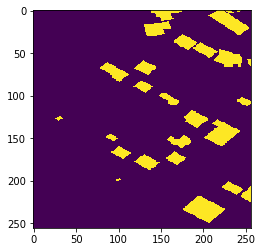

In [25]:
plt.imshow(f.root.AOI_3_Paris_img100)

In [13]:
# Image HDF5 store (RGB)
if Path(FMT_VALTRAIN_IM_STORE.format(prefix)).exists():
    print("Generate RGB_STORE (valtrain) ... skip")
else:
    print("Generate RGB_STORE (valtrain)")
    prep_rgb_image_store_train(area_id, datapath, is_valtrain=True)
if Path(FMT_VALTEST_IM_STORE.format(prefix)).exists():
    print("Generate RGB_STORE (valtest) ... skip")
else:
    print("Generate RGB_STORE (valtest)")
    prep_rgb_image_store_train(area_id, datapath, is_valtrain=False)

  0%|          | 0/803 [00:00<?, ?it/s]/home/ywywywx/miniconda3/envs/fastai/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
  0%|          | 4/803 [00:00<00:20, 39.15it/s]

Generate RGB_STORE (valtrain)
prep_rgb_image_store_train for AOI_3_Paris
Image store file: /data/working/images/v5/valtrain_AOI_3_Paris_im.h5


100%|██████████| 803/803 [01:03<00:00, 12.64it/s]


Generate RGB_STORE (valtest) ... skip


Question: why clip image?

In [44]:
f = tb.open_file('/data/working/images/v5/valtest_AOI_3_Paris_im.h5', 'r'); f

File(filename=/data/working/images/v5/valtest_AOI_3_Paris_im.h5, title='', mode='r', root_uep='/', filters=Filters(complevel=0, shuffle=False, bitshuffle=False, fletcher32=False, least_significant_digit=None))
/ (RootGroup) ''
/AOI_3_Paris_img1009 (CArray(256, 256, 3), shuffle, blosc(9)) ''
  atom := Float64Atom(shape=(), dflt=0.0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (10, 256, 3)
/AOI_3_Paris_img1010 (CArray(256, 256, 3), shuffle, blosc(9)) ''
  atom := Float64Atom(shape=(), dflt=0.0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (10, 256, 3)
/AOI_3_Paris_img1016 (CArray(256, 256, 3), shuffle, blosc(9)) ''
  atom := Float64Atom(shape=(), dflt=0.0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (10, 256, 3)
/AOI_3_Paris_img1021 (CArray(256, 256, 3), shuffle, blosc(9)) ''
  atom := Float64Atom(shape=(), dflt=0.0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (10, 2

In [52]:
sample = list(f.root)[0]; sample

/AOI_3_Paris_img1009 (CArray(256, 256, 3), shuffle, blosc(9)) ''
  atom := Float64Atom(shape=(), dflt=0.0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (10, 256, 3)

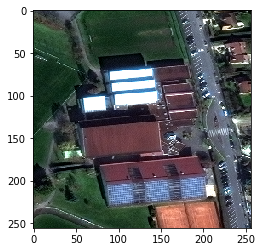

In [51]:
plt.imshow(sample)

### TODO: Try scaling instead of clip?

In [14]:
# Image Mean (RGB)
if Path(FMT_IMMEAN.format(prefix)).exists():
    print("Generate RGBMEAN ... skip")
else:
    print("Generate RGBMEAN")
    prep_immean(area_id, datapath)

Generate RGBMEAN
Prepare mean image: /data/working/images/v5/AOI_3_Paris_immean.h5


In [15]:
f = tb.open_file('/data/working/images/v5/AOI_3_Paris_immean.h5', 'r'); f

File(filename=/data/working/images/v5/AOI_3_Paris_immean.h5, title='', mode='r', root_uep='/', filters=Filters(complevel=0, shuffle=False, bitshuffle=False, fletcher32=False, least_significant_digit=None))
/ (RootGroup) ''
/immean (CArray(3, 256, 256), shuffle, blosc(9)) ''
  atom := Float64Atom(shape=(), dflt=0.0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (1, 32, 256)

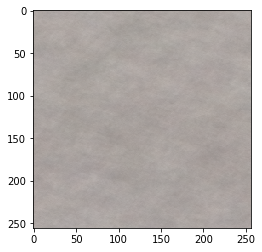

In [34]:
plt.imshow(np.array(list(f.root)[0]).transpose(1, 2, 0) * 3)